In [1]:
##############################
# train with kaggle P100 GPU #
##############################

### Import Libraries

In [2]:
# general libraries
import os
import git
import shutil
import numpy as np
import pandas as pd
import seaborn as sns

# hugging face libraries
from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForImageClassification, 
    TrainingArguments, 
    Trainer
)

# pytorch libraries
import torch
from torchvision.transforms import (
    Compose, 
    Normalize,
    Resize,
    ToTensor
)

# scikit-learn libraries
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# plotting libraries
from  matplotlib import pyplot as plt
%matplotlib inline

### Load Dataset

In [3]:
# dataset directory
######## kaggle ########
# train_dir = '/kaggle/input/ham10000-model-train-no-filtering'
# test_dir = '/kaggle/input/ham10000-model-test'

######## desktop ########
dataset_dir = os.path.abspath('../../../../datasets/HAM10000')
train_dir = os.path.join(dataset_dir, 'dataset-processed/dataset-models/ham10000-model-train-no-filtering')
test_dir = os.path.join(dataset_dir, 'split/test')

In [4]:
# load dataset
train_ds = load_dataset(train_dir)
val_ds = load_dataset(test_dir)

Resolving data files:   0%|          | 0/42294 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/Mominul Islam/.cache/huggingface/datasets/imagefolder/ham10000-model-train-no-filtering-ebd3f71c316f40ed/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/828 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/Mominul Islam/.cache/huggingface/datasets/imagefolder/test-3bd1957c35eba2af/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# loaded dataset structure
print('train_ds: ', train_ds)
print('val_ds: ', val_ds)

train_ds:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 42294
    })
})
val_ds:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 828
    })
})


In [6]:
# num of training and validation samples
print('Training Samples: ', train_ds['train'].num_rows)
print('Validation Samples: ', val_ds['train'].num_rows)

Training Samples:  42294
Validation Samples:  828


In [7]:
# num of features
train_ds['train'].features['label']

ClassLabel(names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], id=None)

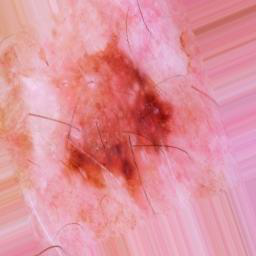

In [8]:
# show image
train_ds['train'][42]['image']

In [9]:
# show label
train_ds['train'][42]['label']

0

In [10]:
# convert labels
labels = train_ds['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [11]:
label2id

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [12]:
id2label

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

### ViT

In [13]:
# download pre-trained model for fine-tuning

######## kaggle ########
# path = '/kaggle/working/ViT'

######## desktop ########
path = os.path.abspath('../../../../repository/ViT')

if os.path.exists(path):
    print("Folder already exist!")
else:
    os.makedirs(path)
    print("Folder successfully created!")
    !git lfs install
    git.Git(path).clone('https://huggingface.co/google/vit-base-patch16-224')
    print("Repository successfully cloned!")

Folder already exist!


In [14]:
# load pre-trained model for fine-tuning

######## kaggle ########
# model_checkpoint = '/kaggle/working/ViT/vit-base-patch16-224'

######## desktop ########
model_checkpoint = os.path.abspath('../../../../repository/ViT/vit-base-patch16-224')

# feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# ViT model
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, 
)

C:\Anaconda\anaconda3\envs\csf-model\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at D:\Research\Archive\cossif\repository\ViT\vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# number of trainable parameters
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for ViT model: ', '{0:.6f}'.format(trainable_parameters/1000000), 'million')

Number of trainable parameters for ViT model:  85.804039 million


In [16]:
# summary of the model
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [17]:
normalize = Normalize(
    mean=feature_extractor.image_mean, 
    std=feature_extractor.image_std
)

######## kaggle ########
# size = feature_extractor.size

######## desktop ########
size = feature_extractor.size['height']

train_transform = Compose([
    Resize(size),
    ToTensor(),
    normalize,
])

val_transform = Compose([
    Resize(size),
    ToTensor(),
    normalize,
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transform(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transform(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [18]:
train_set = train_ds['train']
val_set = val_ds['train']

train_set.set_transform(preprocess_train)
val_set.set_transform(preprocess_val)

In [19]:
######## desktop ########
model_dir = os.path.abspath('../../../../models/HAM10000/ViT/ham10000-vit-no-filtering')

In [20]:
batch_size=32
lr=5e-5
epochs=5

######## kaggle ########
# output_dir = '/kaggle/working/saved_model'

######## desktop ########
output_dir = os.path.join(model_dir, 'saved_model')

args = TrainingArguments(
    output_dir=output_dir,
    remove_unused_columns=False,
    evaluation_strategy = 'steps',
    eval_steps=10,
    save_strategy = 'steps',
    save_steps=10,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    num_train_epochs=epochs,
    optim='adamw_torch',
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='recall',
    save_total_limit=1,
    push_to_hub=False,
    report_to='none'
)

In [21]:
def compute_sensitivity(y_true_flat, y_pred_flat):
    cm=confusion_matrix(y_true_flat, y_pred_flat)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    Sensitivity = TP/(TP+FN)    
    return np.mean(Sensitivity)

def compute_specificity(y_true_flat, y_pred_flat):
    cm=confusion_matrix(y_true_flat, y_pred_flat)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    Specificity = TN/(TN+FP)    
    return np.mean(Specificity)

In [22]:
def compute_metrics(eval_pred):
    logits, y_true_flat = eval_pred
    y_pred_flat = np.argmax(logits, axis=1)
    
    sensitivity = compute_sensitivity(y_true_flat, y_pred_flat)
    specificity = compute_specificity(y_true_flat, y_pred_flat)
    
    precision = float('{0:.6f}'.format(precision_score(y_true_flat, y_pred_flat, average='macro')))
    recall = float('{0:.6f}'.format(recall_score(y_true_flat, y_pred_flat, average='macro')))
    f1 = float('{0:.6f}'.format(f1_score(y_true_flat, y_pred_flat, average='macro')))
    accuracy = float('{0:.6f}'.format(accuracy_score(y_true_flat, y_pred_flat)))

    return {'precision': precision, 
            'recall': recall, 
            'f1': f1, 
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'accuracy': accuracy
           }

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Train

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [24]:
# # train model
# trainer.train()

# # creating downloads directory
# downloads = '/kaggle/working/downloads'

# if os.path.isdir(downloads):
#     print('Folder already exists!')
# else:
#     os.makedirs(downloads)
#     print('Folder created!')

# # save best model
# trainer.save_model(downloads)

# # save training log
# df = pd.DataFrame(trainer.state.log_history)
# df.to_csv('/kaggle/working/downloads/training_log.csv')

## Read CSV

In [25]:
######## kaggle ########
# df = pd.read_csv('/kaggle/working/downloads/training_log.csv')

######## desktop ########
df = pd.read_csv(os.path.join(model_dir, 'training_log.csv'))
df_backup = df

# read training log
df = df[['eval_precision', 
         'eval_recall', 
         'eval_f1', 
         'eval_sensitivity', 
         'eval_specificity',
         'eval_accuracy'
        ]].dropna()

# rename columns
df.rename(columns={'eval_precision':'Precision', 
                   'eval_recall':'Recall', 
                   'eval_f1':'F1-Score', 
                   'eval_sensitivity':'Sensitivity', 
                   'eval_specificity':'Specificity', 
                   'eval_accuracy':'Accuracy'
                  }, inplace = True)

df.head(10)

,Precision,Recall,F1-Score,Sensitivity,Specificity,Accuracy
1,0.032399,0.228157,0.049670,0.228157,0.858388,0.039855
3,0.141529,0.318716,0.075230,0.318716,0.859802,0.057971
5,0.260135,0.399014,0.279011,0.399014,0.911567,0.541063
7,0.413137,0.380809,0.360167,0.380809,0.909649,0.803140
9,0.501744,0.511122,0.473821,0.511122,0.930934,0.835749
11,0.563849,0.580425,0.555452,0.580425,0.952192,0.855072
13,0.603943,0.473277,0.488832,0.473277,0.929110,0.856280
15,0.643680,0.589834,0.603977,0.589834,0.951439,0.873188
17,0.691804,0.605914,0.632639,0.605914,0.960051,0.871981
19,0.743741,0.618897,0.651019,0.618897,0.959348,0.885266


In [26]:
# sort training log
df_sort = df.sort_values('Recall', ascending=False)
df_sort.head(10)

,Precision,Recall,F1-Score,Sensitivity,Specificity,Accuracy
149,0.797582,0.831871,0.811245,0.831871,0.980120,0.917874
47,0.691995,0.815032,0.733810,0.815032,0.979535,0.899758
151,0.802367,0.814788,0.800449,0.814788,0.979659,0.923913
141,0.776618,0.813824,0.793228,0.813824,0.979426,0.917874
185,0.763363,0.807289,0.774394,0.807289,0.977916,0.893720
61,0.760300,0.805985,0.772396,0.805985,0.981097,0.888889
165,0.775947,0.805717,0.777214,0.805717,0.978081,0.913043
87,0.767302,0.805200,0.772996,0.805200,0.983152,0.905797
83,0.785015,0.803934,0.777993,0.803934,0.980464,0.907005
157,0.806162,0.802885,0.801220,0.802885,0.978750,0.917874


## Performance Index

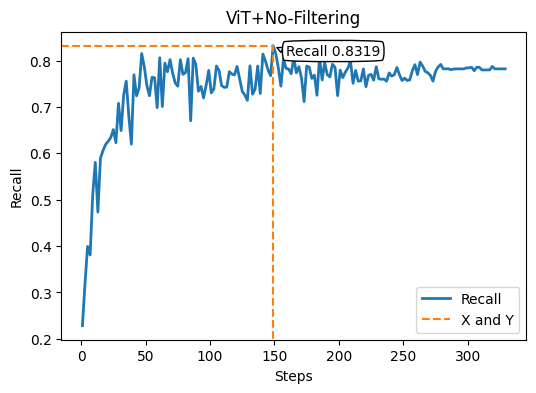

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

x = df['Recall'].index.values.tolist()
y = df['Recall'].values.tolist()

# plot recall 
plt.plot(x, y, lw=2)

# find the index and coordinates of the highest point
idx = np.argmax(y)
x_max = x[idx]
y_max = y[idx]

xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([x[idx], x[idx], xlim[0]], [xlim[0], y[idx], y[idx]], linestyle="--")
plt.xlim(xlim)
plt.ylim(ylim)

plt.annotate(
    'Recall {0:.4f}'.format(max(y)), 
    xy=(x_max, y_max), 
    xytext=(x_max + 10, y_max - 0.02),  
    bbox=dict(boxstyle="round4", fc="w"),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=-0.2", fc="w")
)

plt.title('ViT+No-Filtering')
plt.legend(['Recall', 'X and Y'], loc='lower right')
plt.xlabel('Steps')
plt.ylabel('Recall')
plt.show()

## Training Time

In [28]:
# training time 
last_row = df_backup.iloc[-1]
column_value = last_row['train_runtime']

# convert seconds to hours, minutes, and seconds
hours = int(column_value // 3600)
seconds_remaining = column_value % 3600
minutes = int(seconds_remaining // 60)
seconds = int(seconds_remaining % 60)

# print training time
print(f"Training Time: {hours}:{minutes}:{seconds}")

Training Time: 1:48:3


## Test

In [29]:
######## kaggle ########
# save_path = '/kaggle/working/downloads'
# load_model = save_path

######## desktop ########
save_path = os.path.join(model_dir, 'saved_model')
load_model = save_path

In [30]:
trained_model = AutoModelForImageClassification.from_pretrained(
    load_model, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, 
)

In [31]:
tester = Trainer(
    model=trained_model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [32]:
tester.evaluate()

{'eval_loss': 0.26415887475013733,
 'eval_precision': 0.797582,
 'eval_recall': 0.831871,
 'eval_f1': 0.811245,
 'eval_sensitivity': 0.831871112689527,
 'eval_specificity': 0.9801198734310574,
 'eval_accuracy': 0.917874,
 'eval_runtime': 9.8513,
 'eval_samples_per_second': 84.05,
 'eval_steps_per_second': 2.639}

In [33]:
predictions = tester.predict(test_dataset=val_set).predictions

In [34]:
def to_categorical(y, num_classes):
    """ 1-hot encoding """
    return np.eye(num_classes, dtype='uint8')[y]

def test_set(val_set):
    y = []
    for i in range(val_set.num_rows):
        y.append(val_set[i]['label'])
    return np.array(y)

In [35]:
############## true ##############
# y_true_flat
y_true_flat = test_set(val_set)

# y_true
y_true = to_categorical(y_true_flat, 7)

############## predicted ##############
# y_pred_flat
y_pred_flat = np.argmax(predictions, axis=-1)

# y_pred
y_pred = predictions

In [36]:
############## ROC AUC ##############
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

for i in range(7):
    print(f"{classes[i]} AUC: ", '{0:.4f}'.format(roc_auc_score(y_true[:, i], y_pred[:, i])))

akiec AUC:  0.9695
bcc AUC:  0.9964
bkl AUC:  0.9619
df AUC:  1.0000
mel AUC:  0.8691
nv AUC:  0.9895
vasc AUC:  0.9999


In [37]:
print("Average AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true, y_pred)*100))

Average AUC:  96.95%


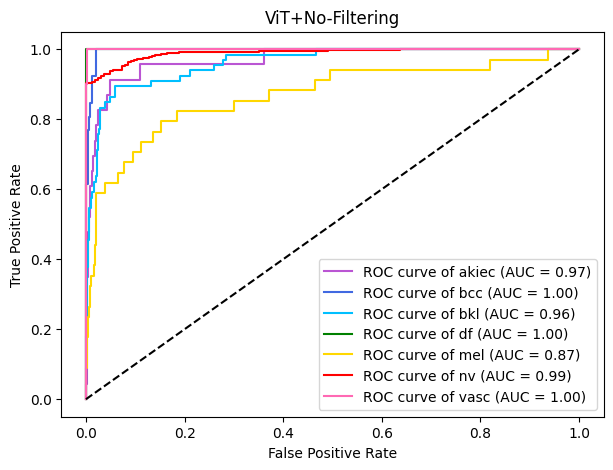

In [38]:
############## AUC ##############
fig, ax = plt.subplots(figsize=(7, 5))

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
colours = ['mediumorchid', 'royalblue', 'deepskyblue', 'green', 'gold', 'red', 'hotpink']

for i in range(7):
    RocCurveDisplay.from_predictions(
        y_true[:, i],
        y_pred[:, i],
        name=f'ROC curve of {classes[i]}',
        color=colours[i],
        ax=ax
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ViT+No-Filtering")
plt.legend()
plt.show()

fig = ax.get_figure()

In [39]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

report = classification_report(y_true_flat, y_pred_flat, target_names=classes)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.59      0.83      0.69        23
         bcc       0.78      0.81      0.79        26
         bkl       0.73      0.77      0.75        66
          df       1.00      1.00      1.00         6
         mel       0.50      0.56      0.53        34
          nv       0.98      0.96      0.97       663
        vasc       1.00      0.90      0.95        10

    accuracy                           0.92       828
   macro avg       0.80      0.83      0.81       828
weighted avg       0.93      0.92      0.92       828



In [40]:
sensitivity = '{0:.2f}'.format(compute_sensitivity(y_true_flat, y_pred_flat)*100)
specificity = '{0:.2f}'.format(compute_specificity(y_true_flat, y_pred_flat)*100)
    
precision = '{0:.2f}'.format(precision_score(y_true_flat, y_pred_flat, average='macro')*100)
recall = '{0:.2f}'.format(recall_score(y_true_flat, y_pred_flat, average='macro')*100)
f1 = '{0:.2f}'.format(f1_score(y_true_flat, y_pred_flat, average='macro')*100)
accuracy = '{0:.2f}'.format(accuracy_score(y_true_flat, y_pred_flat)*100)

matrix_log = [[precision, recall, f1, accuracy, sensitivity, specificity]]
df_result = pd.DataFrame(
    matrix_log, 
    columns=[
        'Precision (%)',
        'Recall (%)', 
        'F1-Score (%)',
        'Accuracy (%)', 
        'Sensitivity (%)', 
        'Specificity (%)'
    ])

df_result = df_result.style.hide(axis='index')
df_result

Precision (%),Recall (%),F1-Score (%),Accuracy (%),Sensitivity (%),Specificity (%)
79.76,83.19,81.12,91.79,83.19,98.01


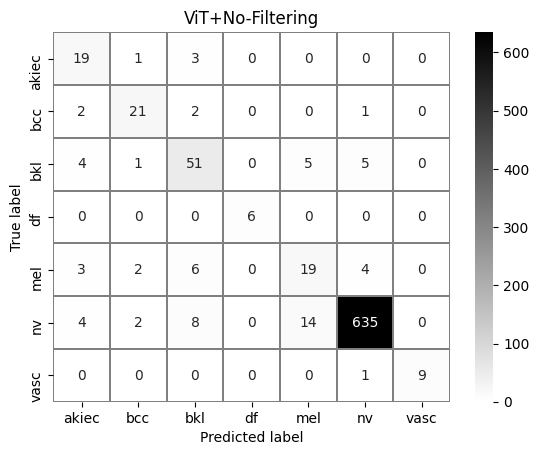

In [41]:
cnf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]

labels = [f"{v1}" for v1 in group_counts]

matrix_labels = np.asarray(labels).reshape(7,7)
axis_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

ax = sns.heatmap(
    cnf_matrix, 
    annot=matrix_labels, 
    fmt='',  
    cmap='binary', 
    linewidths=0.1, 
    linecolor='gray',
    xticklabels=axis_labels, 
    yticklabels=axis_labels
)

sns_figure = ax.set(xlabel='Predicted label', ylabel='True label', title='ViT+No-Filtering')

fig = ax.get_figure()

In [42]:
######## kaggle ########
# downloads = '/kaggle/working/downloads'

# source = downloads
# destination = downloads

# shutil.make_archive(destination, 'zip', source)

In [43]:
############################# kaggle ##############################
# Download the script and folder named 'downloads'.               # 
#                                                                 #
# The 'downloads' folder contains:                                #
#  - the training log file (training_log.csv)                     #
#  - the trained model (saved_model)                              #
#                                                                 #
# Rename the 'downloads' folder to the associated script name.    #
#                                                                 # 
# Move the renamed folder and the script to the current workspace.#
# ----------------------------------------------------------------#
# - models                                                        #
#  - HAM10000                                                     #
#   - Swin-Transformer                                            #
#    - ham10000-vit-no-filtering                                  #
# ----------------------------------------------------------------#
# - scripts                                                       #
#  - HAM10000                                                     #
#   - HAM10000_model_train                                        #
#    - Swin-Transformer                                           #
#     - ham10000-vit-no-filtering.ipynb                           #
###################################################################